In [39]:
import pandas as pd
import numpy as np
import collections
import matplotlib.pyplot as plt
from scipy import stats
%matplotlib inline

In [2]:
df=pd.read_csv("NED27.09.1-D-14.2.0-20170929.csv",skiprows=12)
df=df[np.isnan(df['redshift (z)'])] # only measurements without redshift data are useful here

In [3]:
def selectdata_lite(mymethod,df):
    dfa=df[~np.isfinite(df.err)] # database of non reported errors
    df1=df[np.isfinite(df.err)] # remove measurements that do not report an error
    df1=df1[df1.err!=0] # remove measurements that report an error as zero ¬¬

# Select a method for analysis
    df1=df1[df1.Method==mymethod] # choose a method
    namelist=list(df1['Galaxy ID']) # list of galaxies
    counter=collections.Counter(namelist) # count measurements per galaxy
# Select galaxies with a minimum number of measurements
    ulist=[]
    ulist2=[]
    nmeas=1
    for i in counter.keys():
        if counter[i]>nmeas:
            ulist+=[i] # all galaxies with more than n_meas measurements
        if counter[i]>=1:
            ulist2+=[i] # all galaxies with at least one measurement w/a reported error
    print('No. of Galaxies with reported errors is %i' % len(ulist2) )
    print('No. of Galaxies with more than %i measurements is %i' % (nmeas,len(ulist)) )
# Create database for bootstrap, remove unnecessary columns
    dfs=df1[np.in1d(df1['Galaxy ID'],ulist)] # dataframe with galaxies with more than nmeas measurements
    colu=list(df.columns)
    for i in ['Galaxy ID', 'm-M', 'err', 'D (Mpc)']:
        colu.remove(i)
    dfs.drop(colu, inplace=True, axis=1)
# Create database for non-reported errors
    df1a=dfa[dfa.Method==mymethod] # all measurements without reported errors
    elist=list(np.unique(df1a['Galaxy ID'])) # list of galaxies with measurements without reported errors
    dmeana=[]
    for i in elist:
        dfilter=np.in1d(df1a['Galaxy ID'],i)
        dummy=df1a[dfilter]
        dmeana+=[dummy['D (Mpc)'].mean()] # average reported distance (D), no need for weighted... there are no weights
    filtr=~np.in1d(elist,ulist2)
    nulista=np.asarray(elist)[filtr] # list of galaxies without reported errors
    dista=np.asarray(dmeana)[filtr] # mean distance of galaxies without reported errors
    print('No. of Galaxies without reported errors is %i' % len(nulista) )
    return ulist,dfs,nulista,dista,len(nulista),len(ulist),len(ulist2)

In [4]:
mymethod='Tully-Fisher'
ulist,dfs,nulista,dista,*mma=selectdata_lite(mymethod,df)

No. of Galaxies with reported errors is 11376
No. of Galaxies with more than 1 measurements is 9100


/home/ecci/miniconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


No. of Galaxies without reported errors is 818


In [176]:
booterr=np.percentile(tli, 84,axis=0)-np.percentile(tli, 16,axis=0)
fic=np.random.normal(np.mean(tli),np.mean(booterr)/2,len(tli))

(array([   3.,    4.,    7.,   11.,   19.,   33.,   34.,   46.,   71.,
          96.,  130.,  177.,  220.,  338.,  345.,  457.,  526.,  641.,
         701.,  771.,  837.,  923.,  948.,  952.,  953.,  927.,  881.,
         824.,  730.,  685.,  582.,  444.,  421.,  316.,  267.,  174.,
         150.,   96.,   82.,   61.,   36.,   31.,   21.,   10.,    9.,
           7.,    1.,    0.,    1.,    1.]),
 array([ -1.14162201e+07,  -8.91124395e+06,  -6.40626776e+06,
         -3.90129158e+06,  -1.39631540e+06,   1.10866079e+06,
          3.61363697e+06,   6.11861316e+06,   8.62358934e+06,
          1.11285655e+07,   1.36335417e+07,   1.61385179e+07,
          1.86434941e+07,   2.11484703e+07,   2.36534464e+07,
          2.61584226e+07,   2.86633988e+07,   3.11683750e+07,
          3.36733512e+07,   3.61783274e+07,   3.86833035e+07,
          4.11882797e+07,   4.36932559e+07,   4.61982321e+07,
          4.87032083e+07,   5.12081845e+07,   5.37131607e+07,
          5.62181368e+07,   5.87231130e+07

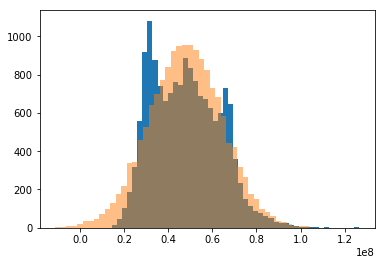

In [177]:
plt.hist(tli,bins=50)
plt.hist(fic,bins=50,alpha=0.5)


In [190]:
def weighted_std(values, weights):
    """
    Return the weighted average and standard deviation.
    Richard M. Brugger, "A Note on Unbiased Estimation of the Standard Deviation", The American Statistician (23) 4 p. 32 (1969)

    values, weights -- Numpy ndarrays with the same shape.
    """
    n=len(values)
    average = np.average(values, weights=weights)
    variance = (n/(n-1.5))*np.average((values-average)**2, weights=weights)  # Fast and numerically precise
    return np.sqrt(variance),average

7


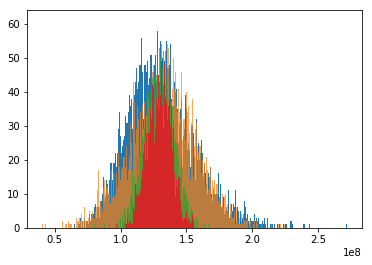

9


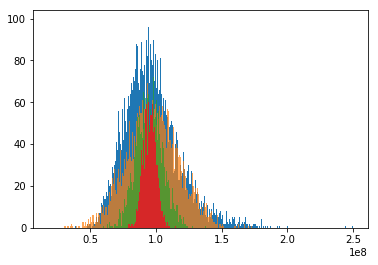

7


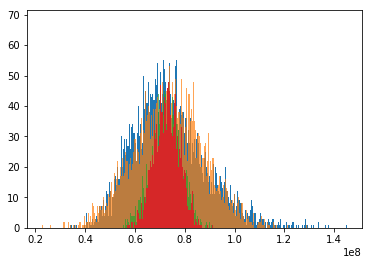

7


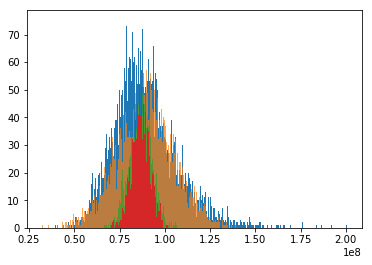

6


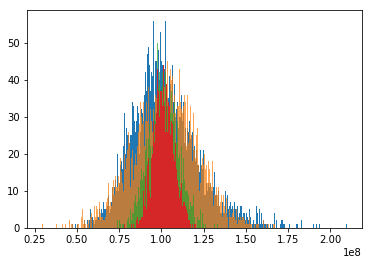

7


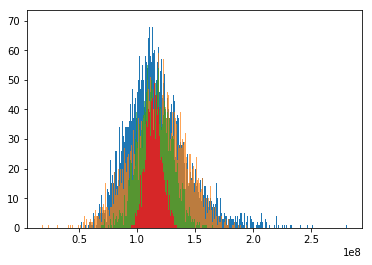

8


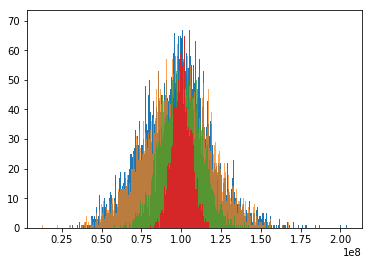

14


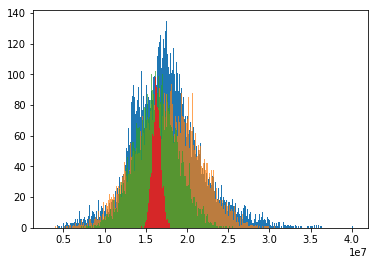

19


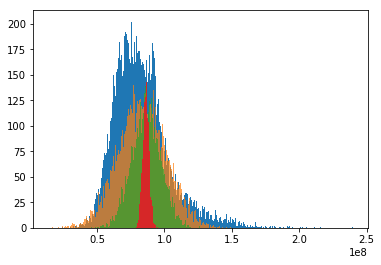

22


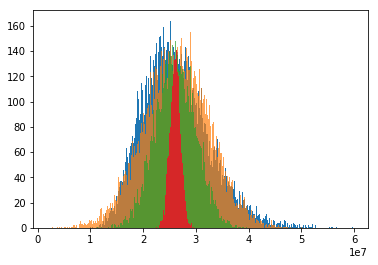

7


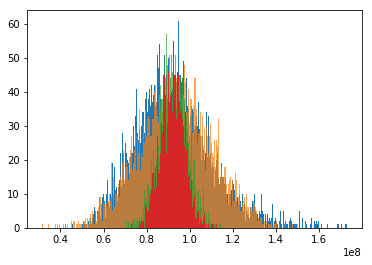

11


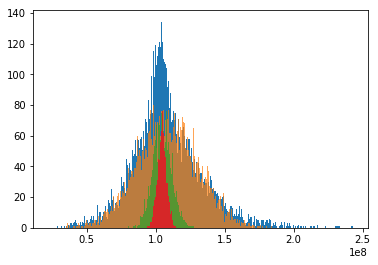

7


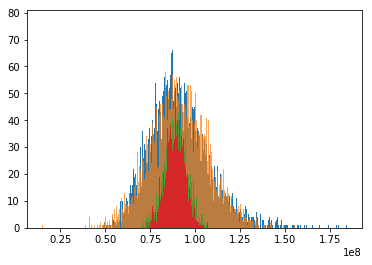

In [194]:
np.random.seed(10)
nbins=1000 # 
for i in ulist[0:50]:
    dfilter=np.in1d(dfs['Galaxy ID'],i)
    dummy=dfs[dfilter]
    if len(dummy) >5:
        print(len(dummy))
        tli=[]
        for km,ke in zip(dummy['m-M'],dummy['err']):
            tli+=list(10**(np.random.normal(km,ke,nbins)/5.+1)) # bootstrap draw for each gal
        booterr=np.percentile(tli, 84,axis=0)-np.percentile(tli, 16,axis=0)
        fic=np.random.normal(np.mean(tli),np.mean(booterr)/2,len(tli))
        bins=500
        wnat,avnat = weighted_std(dummy['m-M'],1/dummy['err']**2)
        distwav=10**(avnat/5+1)
        wsti=0.461*distwav*wnat # weighted standard deviation
        ecfi=0.461*distwav/np.sqrt((1/dummy['err']**2).sum()) # error according to cosmicflows
        eqd=np.sqrt(ecfi**2+wsti**2)   
        #    print(stats.anderson(tli,'norm'))
        fice=np.random.normal(distwav,ecfi,len(tli))
        ficq=np.random.normal(distwav,eqd,len(tli))

        plt.hist(tli,bins=bins)
        plt.hist(fic,bins=bins,alpha=0.7)
        plt.hist(ficq,bins=bins,alpha=0.7)
        plt.hist(fice,bins=bins)

        
        plt.show()
        
        